In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem

In [3]:
import numpy as np

x0 = np.linspace(-1, 0, 300)
y0 = np.cos(x0) * 5 / + 0.1 * np.random.randn(len(x0))
data0 = np.concatenate((x0[:,None], y0[:,None]), axis=1)

x1 = np.linspace(0, 1, 300)
y1 = np.cos(x1) * 5 + 0.1 * np.random.randn(len(x1))
data1 = np.concatenate((x1[:,None], y1[:,None]), axis=1)

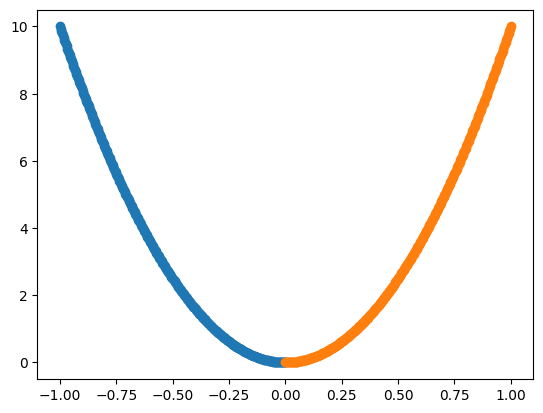

In [178]:
x0 = np.linspace(-1, 0, 300)
x1 = np.linspace(0, 1, 300)

y0 = 10*(x0**2)
y1 = 10*(x1**2)

data1 = np.concatenate((x1[:,None], y1[:,None]), axis=1)
data0 = np.concatenate((x0[:,None], y0[:,None]), axis=1)

plt.scatter(x0,y0)

plt.scatter(x1,y1)

In [179]:
"""x0 = np.linspace(-1, 0, 300)
y0 = 3*np.sqrt(1-x0**2) + 0.01 * np.random.randn(len(x0))
data0 = np.concatenate((x0[:,None], y0[:,None]), axis=1)

x1 = np.linspace(0, 1, 300)
y1 = 3* np.sqrt(1-x1**2) + 0.01 * np.random.randn(len(x0))
data1 = np.concatenate((x1[:,None], y1[:,None]), axis=1)
plt.scatter(x0, y0)
plt.scatter(x1, y1)"""

'x0 = np.linspace(-1, 0, 300)\ny0 = 3*np.sqrt(1-x0**2) + 0.01 * np.random.randn(len(x0))\ndata0 = np.concatenate((x0[:,None], y0[:,None]), axis=1)\n\nx1 = np.linspace(0, 1, 300)\ny1 = 3* np.sqrt(1-x1**2) + 0.01 * np.random.randn(len(x0))\ndata1 = np.concatenate((x1[:,None], y1[:,None]), axis=1)\nplt.scatter(x0, y0)\nplt.scatter(x1, y1)'

In [180]:
from ott.geometry.pointcloud import PointCloud
from ott.geometry.geometry import Geometry
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn

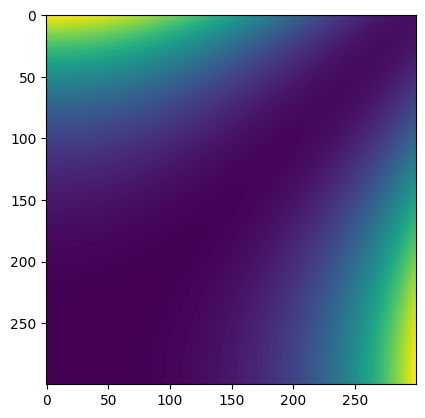

In [181]:
plt.imshow(PointCloud(data0, data1).cost_matrix)

In [182]:
lp = LinearProblem(PointCloud(data0, data1, epsilon=1e-3))

In [183]:
out = Sinkhorn()(lp)

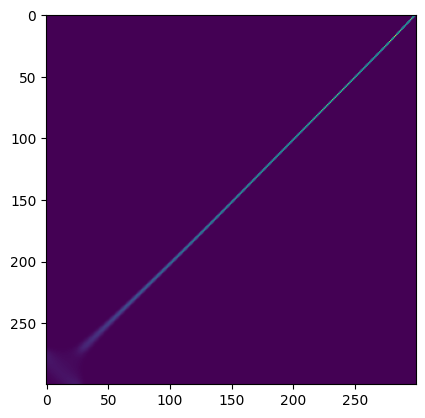

In [184]:
plt.imshow(out.matrix)

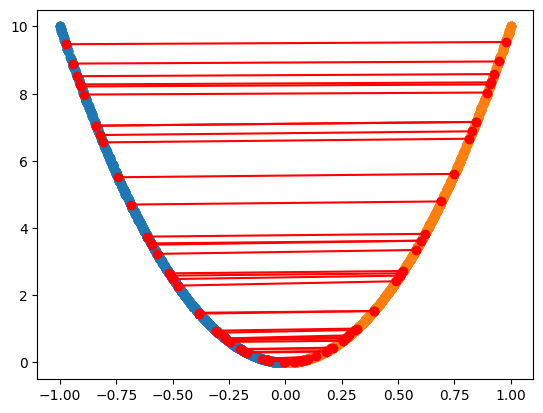

In [187]:
pi_star_inds = jax.random.categorical(
        jax.random.PRNGKey(0), logits=jnp.log(out.matrix.flatten()), shape=(1000,)
    )
inds_source = pi_star_inds // 300
inds_target = pi_star_inds % 300
source_gt = data0[inds_source]
target_gt = data1[inds_target]

plt.scatter(source_gt[:,0], source_gt[:,1])
plt.scatter(target_gt[:,0], target_gt[:,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (40,), 0, len(source_gt))
plt.plot([source_gt[indices, 0],target_gt[indices, 0]],[source_gt[indices, 1],target_gt[indices, 1]] ,'ro-')
plt.show()

In [161]:
import jax

batch_0 = data0[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0)).sort()]
batch_1 = data1[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data1)).sort()]


#batch_0 = data0[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0))]
#batch_1 = data1[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data1))]

In [188]:
source_flattened = data0
t_xz_flattened = data1

In [242]:


def get_nearest_neighbors(
    X: jnp.ndarray, Y: jnp.ndarray, len_x: int, k: int = 30  # type: ignore[name-defined]
) -> Tuple[jnp.ndarray, jnp.ndarray]:  # type: ignore[name-defined]
    concat = jnp.concatenate((X,Y), axis=0)
    pairwise_euclidean_distances = pointcloud.PointCloud(concat, concat).cost_matrix
    distances, indices = jax.lax.approx_min_k(pairwise_euclidean_distances, k=k, recall_target=0.95, aggregate_to_topk=True)
    return distances, indices

k_neighbors = 600#len(source_flattened)+1
distances, indices = get_nearest_neighbors(source_flattened, t_xz_flattened, len(source_flattened), k_neighbors)
distances = distances**4
a = jnp.zeros((len(source_flattened)+ len(t_xz_flattened), len(source_flattened)+ len(t_xz_flattened)))
#print(a.shape, len(source_flattened), distances.shape, indices.shape)
adj_matrix = a.at[jnp.repeat(jnp.arange(len(source_flattened)+len(t_xz_flattened)), repeats=k_neighbors).flatten(), indices.flatten()].set(distances.flatten())
cm = ott.geometry.graph.Graph.from_graph(adj_matrix, normalize=True).cost_matrix


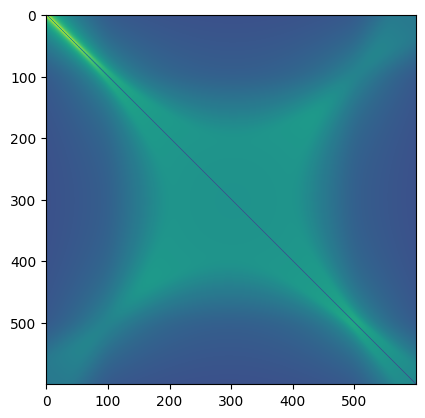

In [243]:
plt.imshow(cm)

In [244]:
geom = geometry.Geometry(cm[:300, 300:], epsilon=1e-4)
sinkhorn_output = sinkhorn.Sinkhorn()(
            linear_problem.LinearProblem(geom)  # linear_problem.LinearProblem(geom, a=a, b=b)
        )
sinkhorn_output.reg_ot_cost

Array(0.01703132, dtype=float32)

In [245]:
id_displacement = jnp.mean(jnp.diag(cm[:300, 300:]))
id_displacement

Array(0.01787422, dtype=float32)

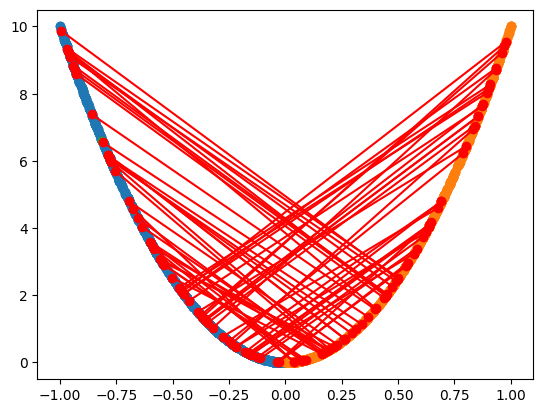

In [247]:
pi_star_inds = jax.random.categorical(
        jax.random.PRNGKey(0), logits=jnp.log(sinkhorn_output.matrix.flatten()), shape=(1000,)
    )
inds_source = pi_star_inds // 300
inds_target = pi_star_inds % 300
source_gt = data0[inds_source]
target_gt = data1[inds_target]

plt.scatter(source_gt[:,0], source_gt[:,1])
plt.scatter(target_gt[:,0], target_gt[:,1])
plt.scatter(source_gt[0,0], source_gt[0,1])
plt.scatter(target_gt[0,0], target_gt[0,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (60,), 0, len(source_gt))
plt.plot([source_gt[indices, 0],target_gt[indices, 0]],[source_gt[indices, 1],target_gt[indices, 1]] ,'ro-')
plt.show()

In [248]:
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem



@partial(jax.jit, static_argnames=["len_x", "k"])
def get_nearest_neighbors(
    X: jnp.ndarray, Y: jnp.ndarray, len_x: int, k: int = 30  # type: ignore[name-defined]
) -> Tuple[jnp.ndarray, jnp.ndarray]:  # type: ignore[name-defined]
    concat = jnp.concatenate((X,Y), axis=0)
    pairwise_euclidean_distances = pointcloud.PointCloud(concat, concat).cost_matrix
    distances, indices = jax.lax.approx_min_k(pairwise_euclidean_distances, k=k, recall_target=0.95, aggregate_to_topk=True)

    
    
    ped_xy = pairwise_euclidean_distances[:len_x, len_x:]
    #min_ped_xy = jnp.min(ped_xy)
    col_index = jnp.argmin(jnp.min(ped_xy, axis=1))
    row_index = jnp.argmin(jnp.min(ped_xy, axis=0))
    ped_xy_computed = jnp.linalg.norm(X[row_index] - X[col_index], norm=2)
    distances = distances.at[row_index, 0].set(ped_xy_computed)
    indices = indices.at[row_index, 0].set(col_index)
    
    return distances, indices


class KantorovichGap:
    def __init__(
        self,
        noise_dim: int,
        geometry_kwargs: Mapping[str, Any] = MappingProxyType({}),
        sinkhorn_kwargs: Mapping[str, Any] = MappingProxyType({}),
    ) -> None:
        self.geometry_kwargs = geometry_kwargs
        self.sinkhorn_kwargs = sinkhorn_kwargs
        self.noise_dim = noise_dim

    def __call__(
        self,
        a: Optional[jnp.ndarray],
        source: jnp.ndarray,
        b: Optional[jnp.ndarray],
        T: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray],
    ) -> Union[float, Any]:
        

        T_xz = T(source)
        source_flattened = jnp.reshape(source[..., : -self.noise_dim], (source.shape[0], -1))
        t_xz_flattened = jnp.reshape(T_xz, (T_xz.shape[0], -1))

        k_neighbors =len(source)+len(t_xz_flattened)
        distances, indices = get_nearest_neighbors(source_flattened, t_xz_flattened, len(source), k_neighbors)
        #distances = distances**2
        
        adj_matrix = jnp.zeros((len(source_flattened)+ len(t_xz_flattened), len(source_flattened)+ len(t_xz_flattened)))
        adj_matrix = adj_matrix.at[jnp.repeat(jnp.arange(len(source_flattened)+len(t_xz_flattened)), repeats=k_neighbors).flatten(), indices.flatten()].set(distances.flatten())
        cm = ott.geometry.graph.Graph.from_graph(adj_matrix, normalize=True).cost_matrix
       
        #jax.debug.print("cm.sum is {x}", x=(cm.sum(axis=0)==0).sum())
        #jax.debug.print("cm.sum is {x}", x=(cm.sum(axis=1)==0).sum())
        cost_red = cm[:len(source_flattened), len(source_flattened):]
        cost_red = cost_red/cost_red.mean()
        geom = geometry.Geometry(cost_red, epsilon=1e-2)
        
        
        id_displacement = jnp.mean(jnp.diag(cost_red)) # note this only works for k_samples_per_x==1
        sinkhorn_output = sinkhorn.Sinkhorn(max_iterations=1e7, **self.sinkhorn_kwargs)(
            linear_problem.LinearProblem(geom)  # linear_problem.LinearProblem(geom, a=a, b=b)
        )
        opt_displacement = sinkhorn_output.reg_ot_cost - 2 * geom.epsilon * jnp.log(
            len(source)
        )  # use Shannon entropy instead of relative entropy as entropic regularizer to ensure Monge gap positivity

        return id_displacement - opt_displacement, sinkhorn_output
        #return source, T_xz

    




In [249]:
kant_gap = KantorovichGap(noise_dim=4)

In [290]:
from entot.plotting.plots import scatter_plot_2d
from entot.models.models import KantorovichGapModel

lambda_kant_gap = np.linspace(100, 0, 600) 
lambda_kant_gap = [lambda_kant_gap[i] for i in range(len(lambda_kant_gap))] + [1.0] * 10000
kg = KantorovichGapModel(epsilon_kant_gap=1e-2, input_dim=[2], k_noise_per_x=1, iterations=1000, lambda_kant_gap=lambda_kant_gap, callback=scatter_plot_2d, callback_iters=100, scale_cost_fitting_term="mean")

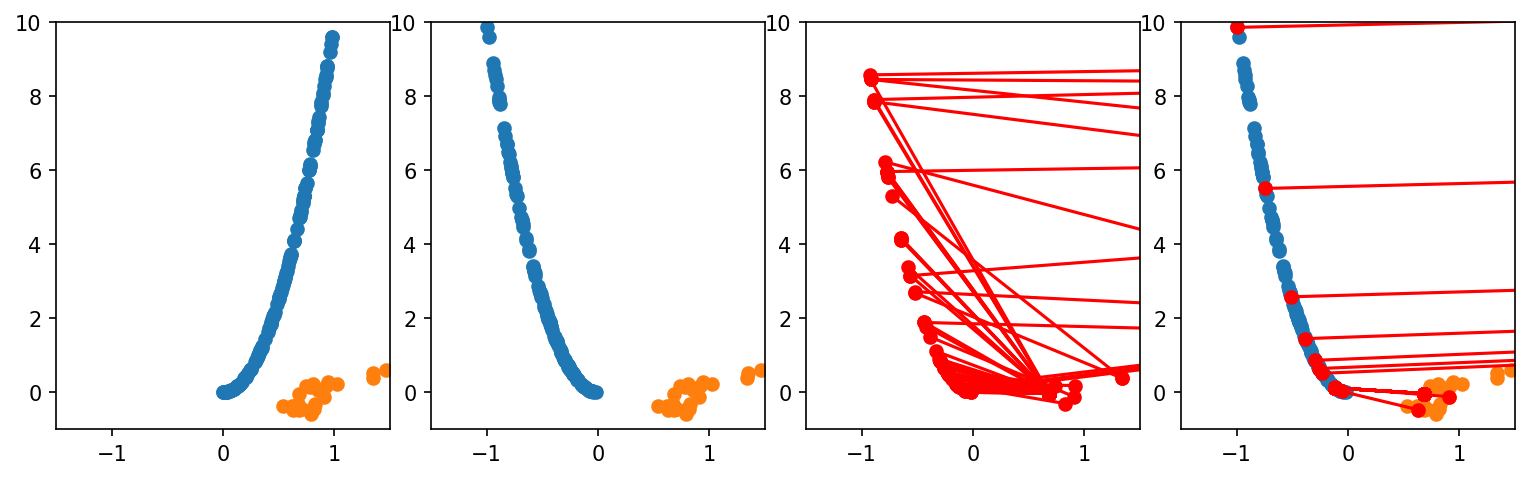

100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


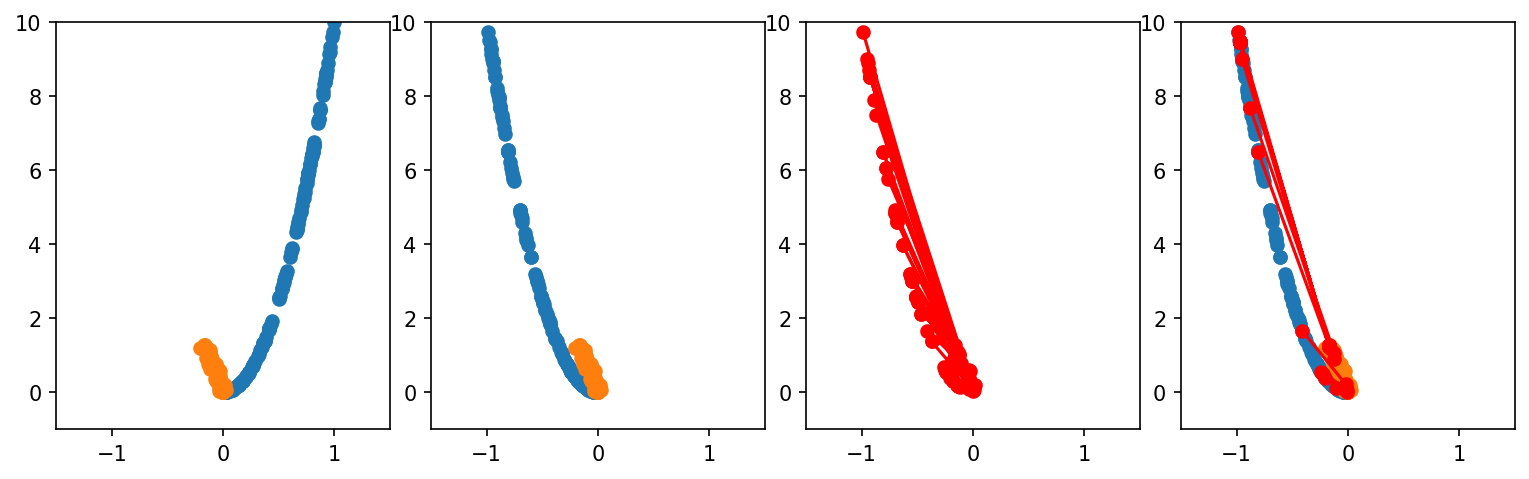

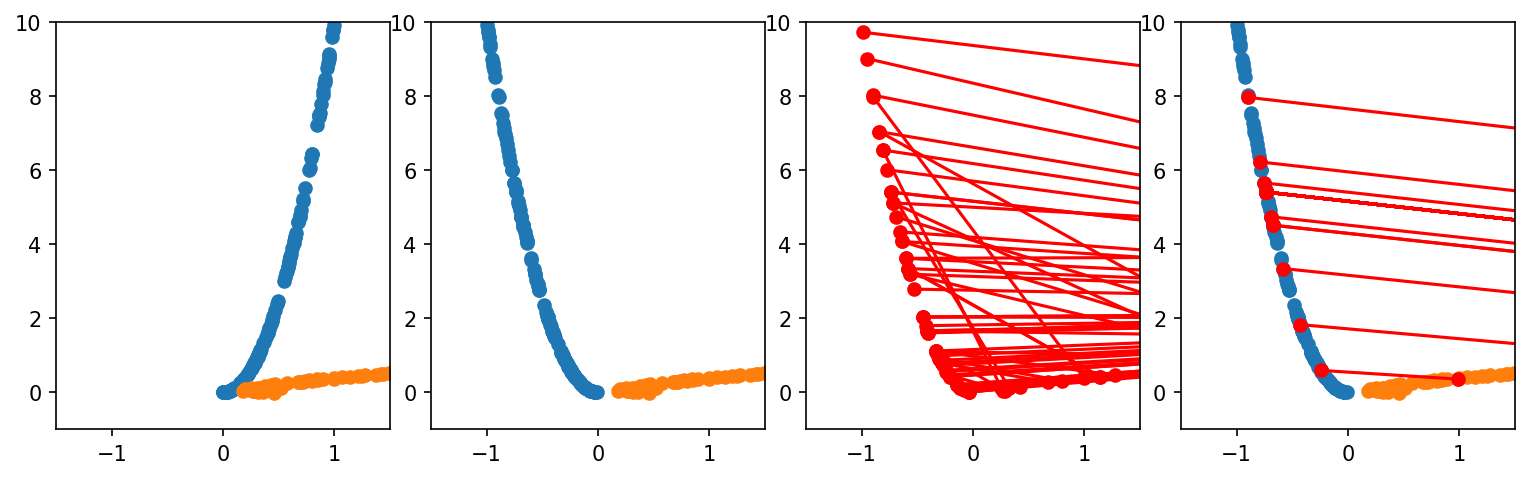

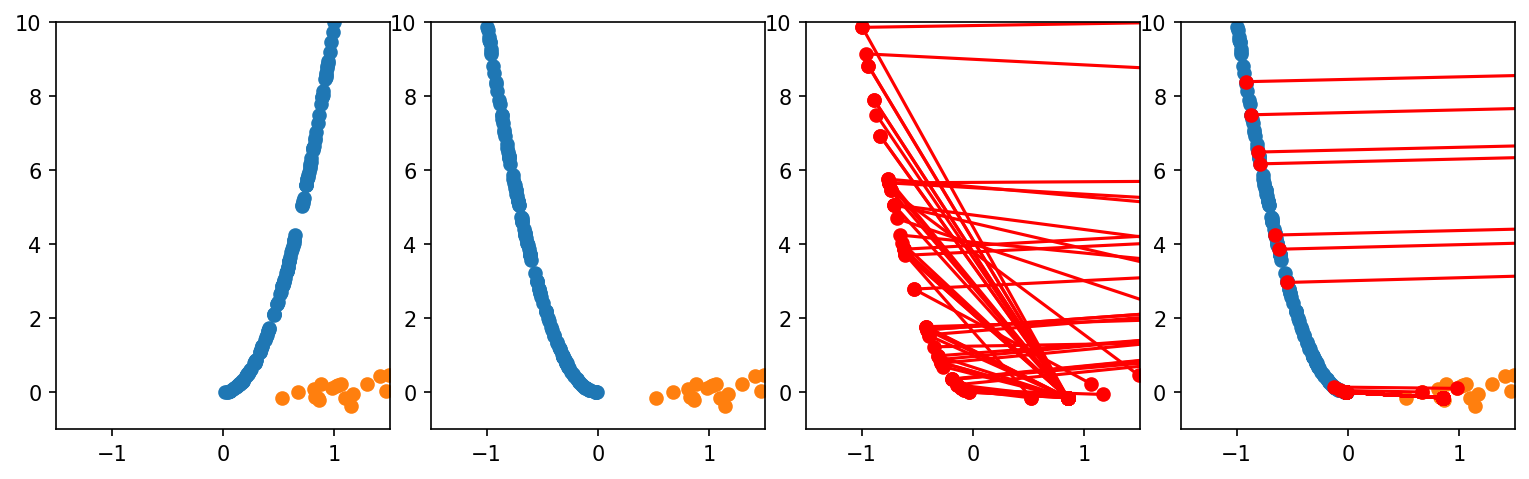

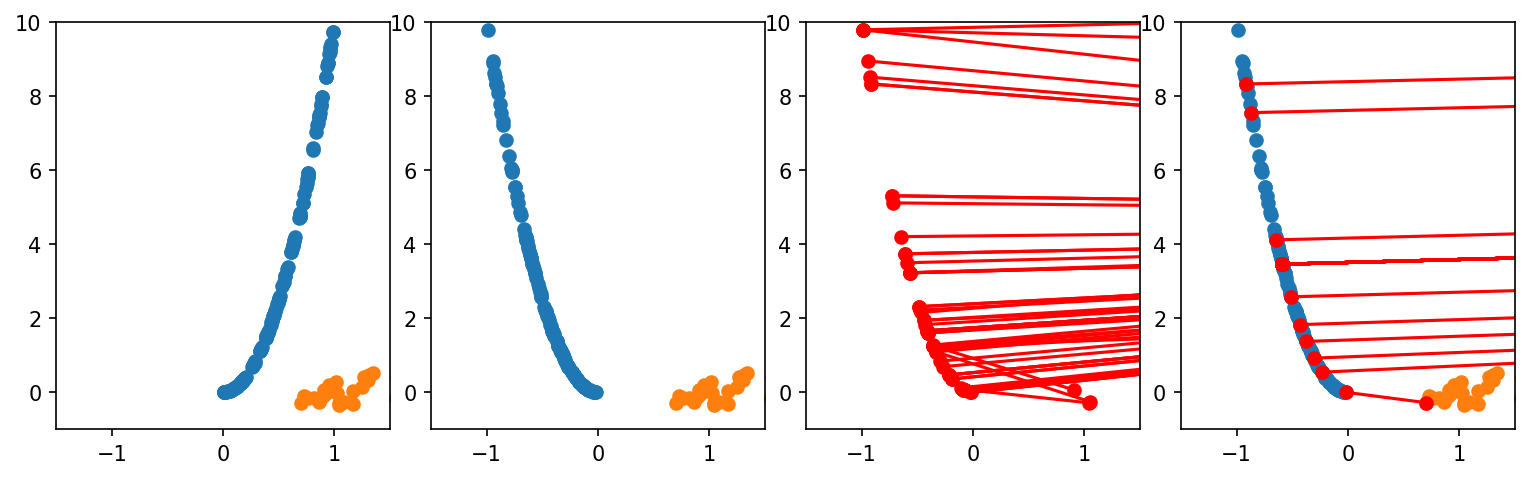

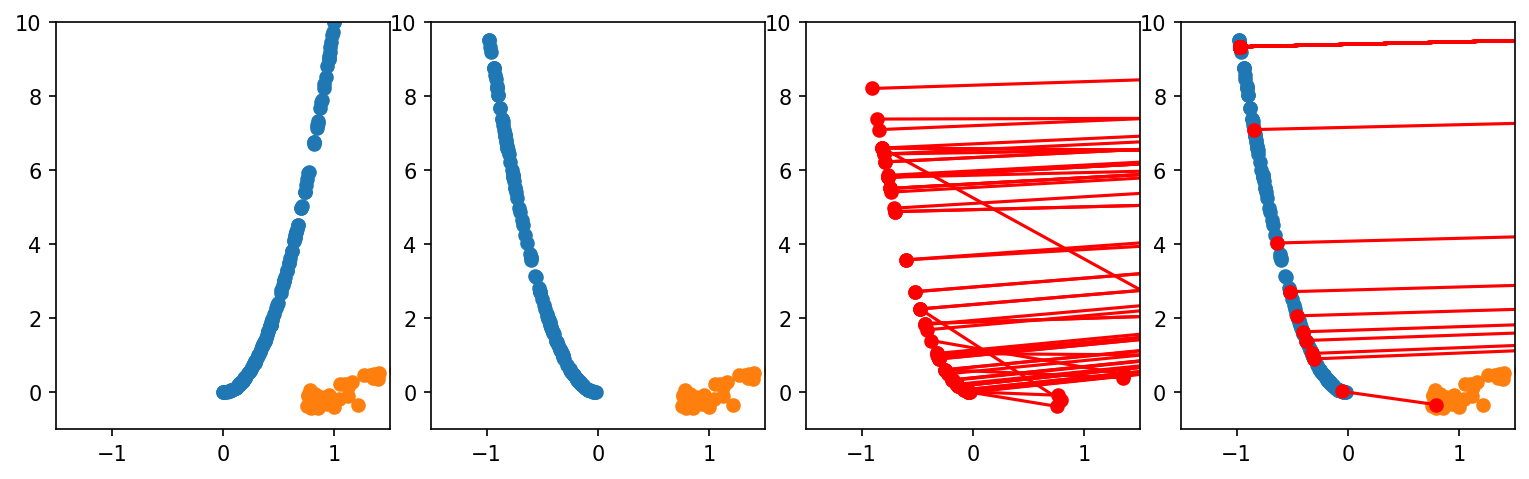

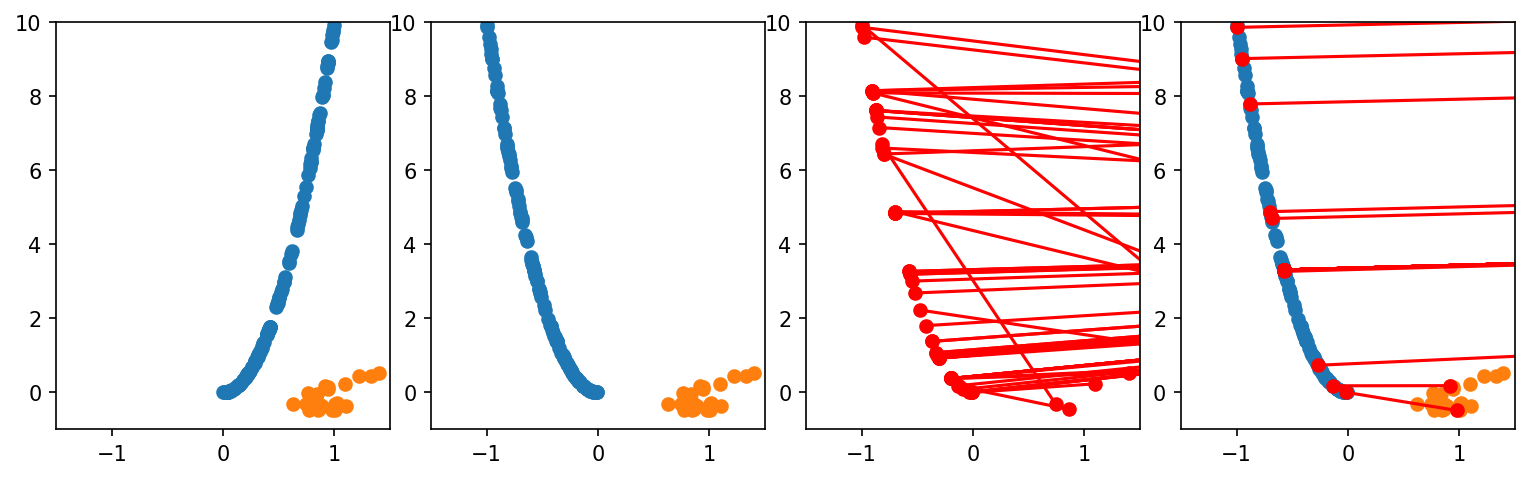

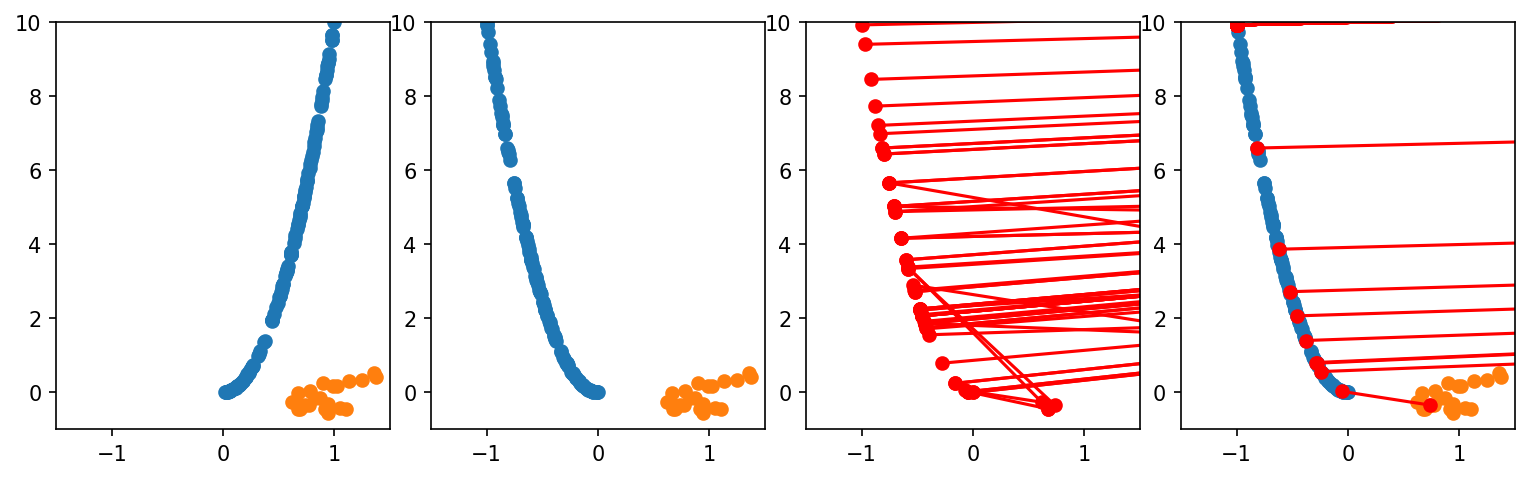

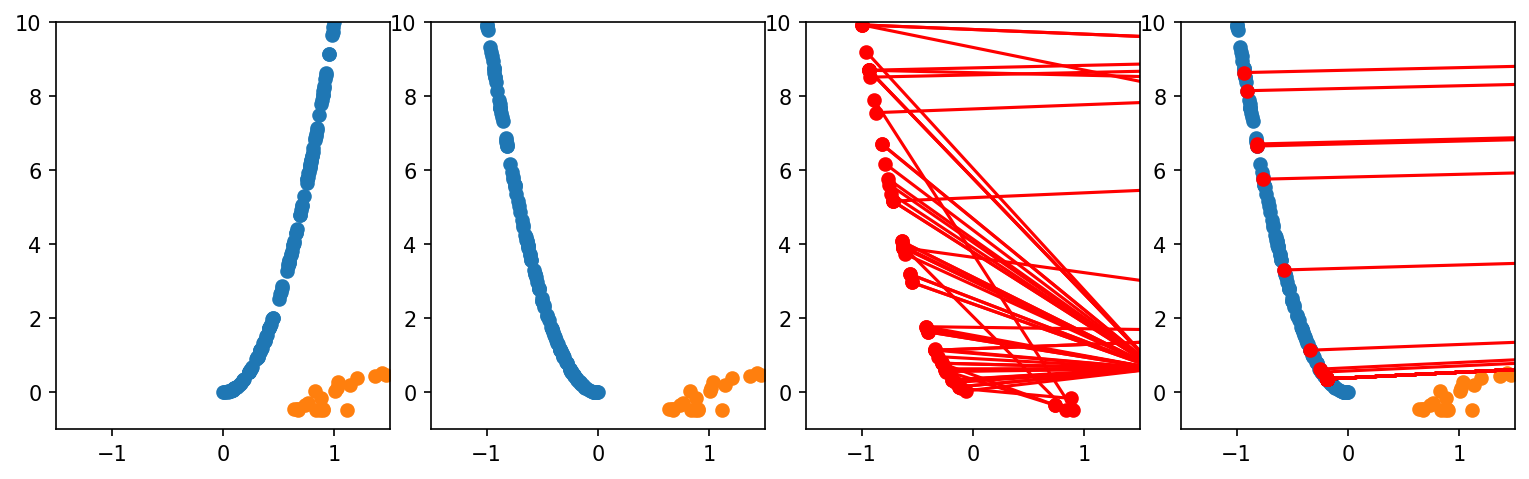

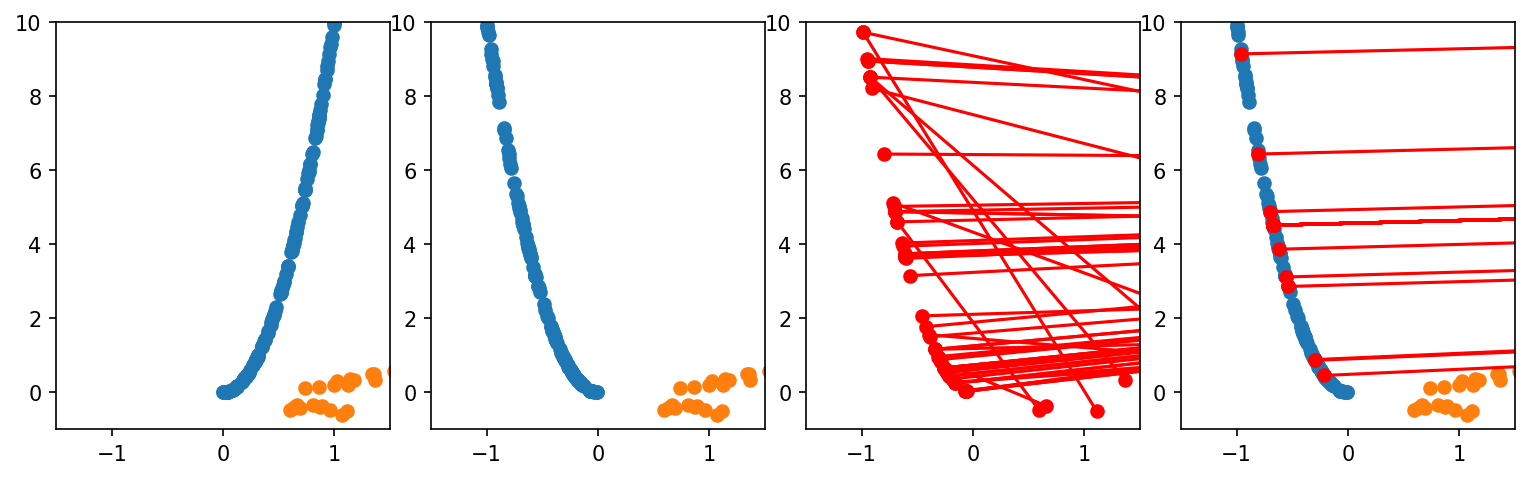

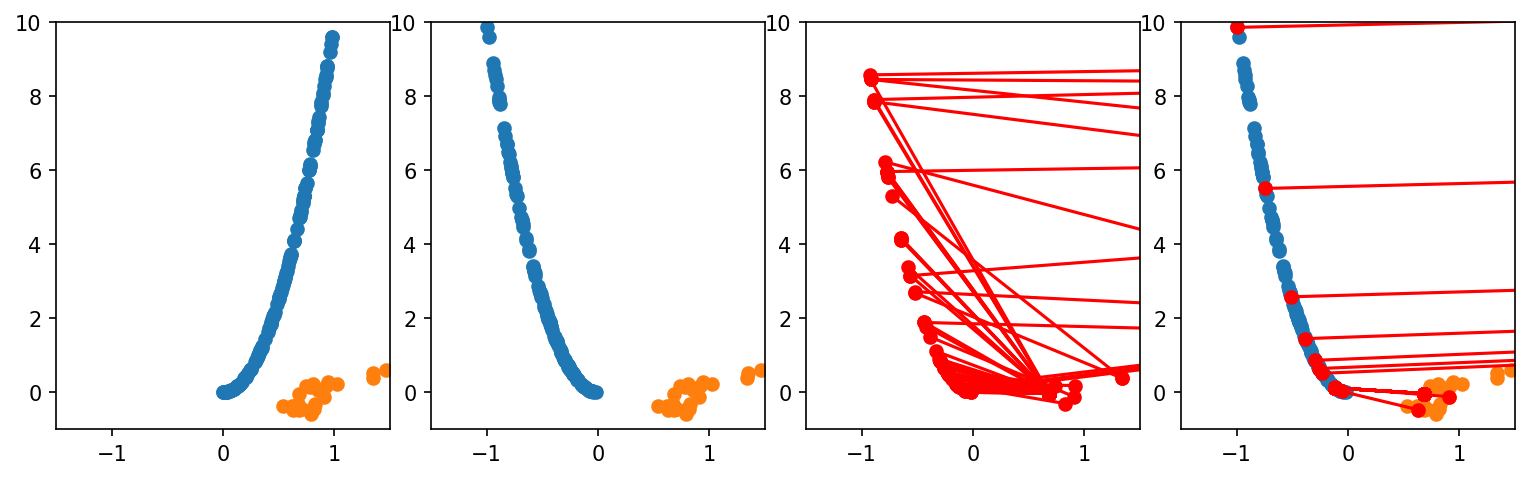

In [291]:
#kg(jnp.array(data0)[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0))], jnp.array(data1)[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0))], 64, 64)
kg(data0, data1, 128, 128)

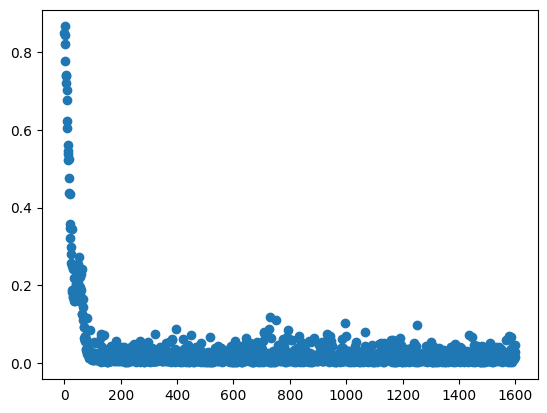

In [276]:
plt.scatter(np.arange(len(kg.metrics['fitting_loss'])), kg.metrics['fitting_loss'])

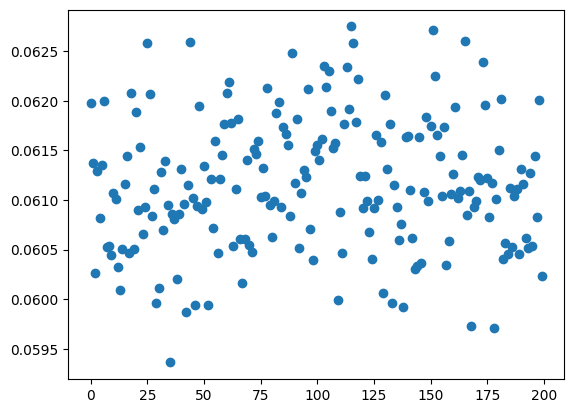

In [277]:
plt.scatter(np.arange(len(kg.metrics['fitting_loss'][1400:])), kg.metrics['scaled_kant_gap'][1400:])

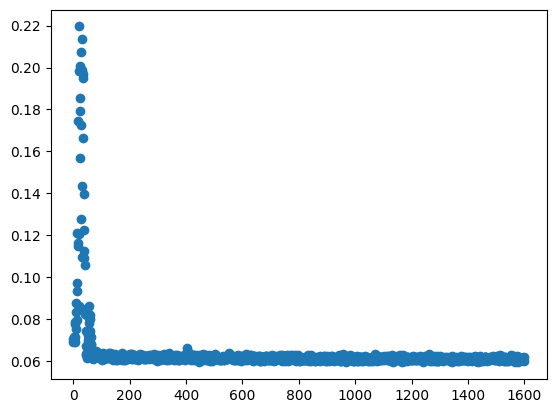

In [278]:
plt.scatter(np.arange(len(kg.metrics['fitting_loss'])), kg.metrics['kant_gap'])

In [279]:
pushed_source = kg.transport(data0, 1, 0)

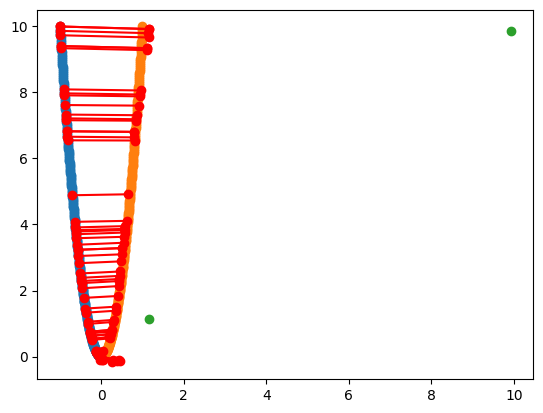

In [286]:
plt.scatter(data0[:,0], data0[:,1])
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(pushed_source[:,0], pushed_source[:,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (60,), 0, len(data0))

plt.plot([data0[indices, 0],pushed_source[0, indices, 0]],[data0[indices, 1],pushed_source[0, indices, 1]] ,'ro-')
plt.show()

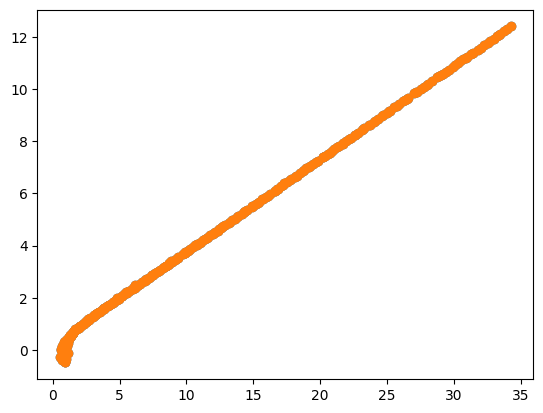

In [266]:
plt.scatter(pushed_source[0,:,0], pushed_source[0,:,1])
plt.scatter(pushed_source[1,:,0], pushed_source[1,:,1])

In [570]:
(pushed_source[1,...] - pushed_source[0,...]).min()

Array(0., dtype=float32)

In [ ]:
batch = {}
latent_batch = kg.noise_fn(jax.random.PRNGKey(0), shape=(64,4)) * kg.std
x_with_noise = jnp.concatenate((jnp.array(data0)[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0))], latent_batch), axis=-1)
batch["source"] = x_with_noise
batch["target"] = jnp.array(data1)[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0))]

In [ ]:
d1, d2 = kg.neural_kant_gap(kg.state_neural_net.params, kg.state_neural_net.apply_fn, batch)

distances are [[0.         0.01398107 0.02113572 ...        nan        nan        nan]
 [0.         0.04416167 0.12279099 ...        nan        nan        nan]
 [0.         0.         0.04390897 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
adj_matrix is (128, 128)
cm [[873.3655 873.3655 873.3655 ... 873.3655 873.3655 873.3655]
 [873.3655 873.3655 873.3655 ... 873.3655 873.3655 873.3655]
 [873.3655 873.3655 873.3655 ... 873.3655 873.3655 873.3655]
 ...
 [873.3655 873.3655 873.3655 ... 873.3655 873.3655 873.3655]
 [873.3655 873.3655 873.3655 ... 873.3655 873.3655 873.3655]
 [873.3655 873.3655 873.3655 ... 873.3655 873.3655 873.3655]]
output converged True
id_displacement 0.9999987483024597
sinkhorn_output.reg_ot_cost 0.9999988079071045


In [ ]:
d1

Array([[-4.44816053e-01,  4.40719414e+00,  1.43494517e-01,
        -1.29313832e-02,  1.64265856e-01, -1.00759268e-01],
       [-5.78595340e-01,  4.15445232e+00, -3.99416685e-02,
         8.08541179e-02, -3.52311842e-02, -6.16833232e-02],
       [-6.75585270e-01,  3.80886817e+00,  2.03204285e-02,
         1.21893384e-01,  1.33507237e-01,  7.09575543e-04],
       [-8.19397986e-01,  3.57670593e+00,  8.36631805e-02,
         3.68177928e-02,  8.27411264e-02,  2.03202248e-01],
       [-9.33110356e-01,  2.91912627e+00, -8.15635268e-03,
         1.32949380e-02,  1.25910684e-01,  9.77779850e-02],
       [-2.54180610e-01,  4.80222654e+00, -1.41593561e-01,
         9.71252024e-02, -1.13545977e-01, -4.09027487e-02],
       [-7.22408056e-01,  4.04922056e+00, -1.74505726e-01,
         4.30926643e-02,  1.00116134e-01, -4.63999622e-02],
       [-8.96321058e-01,  3.19924259e+00, -3.19067203e-02,
         5.93072437e-02, -2.78891828e-02, -5.38751148e-02],
       [-1.77257523e-01,  5.03146458e+00, -1.114

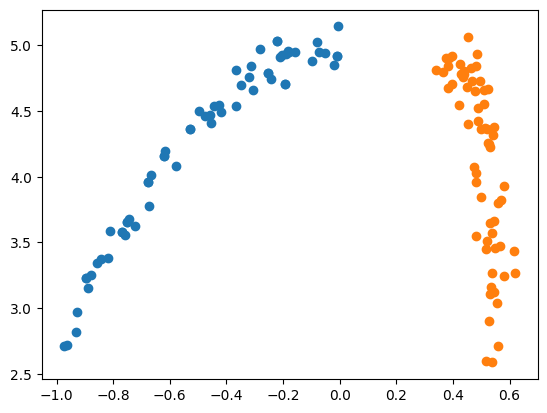

In [ ]:
plt.scatter(d1[:,0], d1[:,1])
plt.scatter(d2[:,0], d2[:,1])

In [ ]:
d1.shape, d2.shape

((64, 6), (64, 2))

In [ ]:
source_flattened = d1[:, :2]
t_xz_flattened = d2

In [ ]:
def get_nearest_neighbors(
    X: jnp.ndarray, k: int = 30  # type: ignore[name-defined]
) -> Tuple[jnp.ndarray, jnp.ndarray]:  # type: ignore[name-defined]
    pairwise_euclidean_distances = pointcloud.PointCloud(X, X).cost_matrix
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices
k_neighbors=30

distances, indices = get_nearest_neighbors(jnp.concatenate((source_flattened, t_xz_flattened), axis=0), k_neighbors)
a = jnp.zeros((len(source_flattened)+ len(t_xz_flattened), len(source_flattened)+ len(t_xz_flattened)))
#print(a.shape, len(source_flattened), distances.shape, indices.shape)
adj_matrix = a.at[jnp.repeat(jnp.arange(len(source_flattened)+len(t_xz_flattened)), repeats=k_neighbors).flatten(), indices.flatten()].set(distances.flatten())
cm = ott.geometry.graph.Graph.from_graph(adj_matrix, normalize=True, t=10).cost_matrix

In [ ]:
k_neighbors=10
distances, indices = get_nearest_neighbors(source_flattened, t_xz_flattened, len(source_flattened), k_neighbors)

In [ ]:
adj_matrix = a.at[jnp.repeat(jnp.arange(len(source_flattened)+len(t_xz_flattened)), repeats=k_neighbors).flatten(), indices.flatten()].set(distances.flatten())

In [ ]:
(adj_matrix).sum(axis=0) == 0

Array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]

In [ ]:
cm = ott.geometry.graph.Graph.from_graph(adj_matrix+adj_matrix.T, normalize=True, t=10).cost_matrix

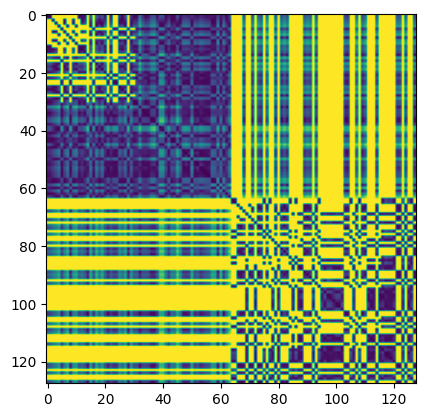

In [ ]:
plt.imshow(cm)

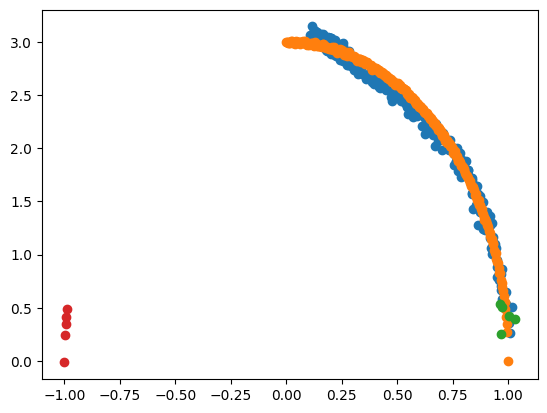

In [571]:
plt.scatter(pushed_source[0,:,0], pushed_source[0,:,1])
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(pushed_source2[0,:,0], pushed_source2[0,:,1])
plt.scatter(data0[:5][:,0], data0[:5][:,1])

In [ ]:
from  sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path

graph = kneighbors_graph(data, 5)
path_distances = shortest_path(graph, directed = False)

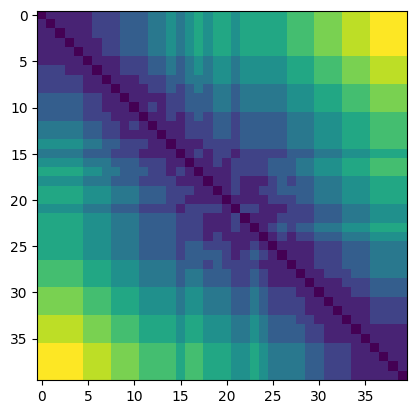

In [ ]:
plt.imshow(path_distances)

In [ ]:
cm_red = path_distances[:20, 20:]

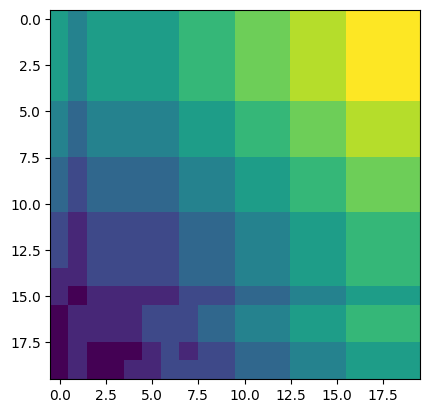

In [ ]:
plt.imshow(cm_red)

In [ ]:
out = ott.solvers.linear.sinkhorn.Sinkhorn()(ott.problems.linear.linear_problem.LinearProblem(ott.geometry.geometry.Geometry(cm_red, epsilon=1e-1)))